# LAB 5: Text classification with Naive Bayes

Objectives:

* Train and evaluate Naive Bayes text classifiers
* Cross-validation
* Hyperparameter search

In [1]:
import numpy as np
import pandas as pd
from cytoolz import *
from tqdm.auto import tqdm

tqdm.pandas()

### Load and preprocess data

In [2]:
df = pd.read_parquet(
    "s3://ling583/rcv1-politics.parquet", storage_options={"anon": True}
)

In [3]:
import spacy

nlp = spacy.load(
    "en_core_web_sm",
    exclude=["tagger", "parser", "ner", "lemmatizer", "attribute_ruler"],
)

In [4]:
def tokenize(text):
    doc = nlp.tokenizer(text)
    return [t.norm_ for t in doc if t.is_alpha]

In [5]:
df["tokens"] = df["text"].progress_apply(tokenize)

  0%|          | 0/60509 [00:00<?, ?it/s]

----

### Multinomial Naive Bayes

In [19]:
# import all libraries 
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import make_pipeline
from sklearn.dummy import DummyClassifier
from sklearn.metrics import classification_report, f1_score
from sklearn.model_selection import StratifiedKFold, cross_val_predict, cross_val_score

Set up a pipeline: first convert tokenized text into feature vectors, then apply naive Bayes classifier

In [17]:
mnb = make_pipeline(CountVectorizer(analyzer=identity), MultinomialNB())

Set up Cross validation, we can use the same parameters as Bernoulli script. 

In [21]:
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=5432)

In [22]:
predicted = cross_val_predict(mnb, df["tokens"], df["pol"], cv=cv, n_jobs=-1)
print(classification_report(df["pol"], predicted))

              precision    recall  f1-score   support

       False       0.99      0.90      0.95     56243
        True       0.41      0.92      0.57      4266

    accuracy                           0.90     60509
   macro avg       0.70      0.91      0.76     60509
weighted avg       0.95      0.90      0.92     60509



F1 scores is .57, which is very good without doing any hyperparameter search. The true precision is less than .50. And accuracry is .90, which is very good. However, we would still look for more precise parameters to have a better model. 

---

### Hyperparameter search

In [23]:
from dask.distributed import Client

client = Client("tcp://127.0.0.1:36235")
client

Client Scheduler: tcp://127.0.0.1:36235 Dashboard: http://127.0.0.1:8787/status,Cluster Workers: 4 Cores: 4 Memory: 16.62 GB


In [24]:
from dask_ml.model_selection import RandomizedSearchCV
from scipy.stats.distributions import loguniform, randint, uniform

In [25]:
from warnings import simplefilter
simplefilter(action="ignore", category=FutureWarning)

In [27]:
%%time

search = RandomizedSearchCV(
    mnb, {"multinomialnb__alpha": loguniform(1e-10, 10.0)}, n_iter=25, scoring="f1"
)
search.fit(df["tokens"], df["pol"])

CPU times: user 21.1 s, sys: 2.77 s, total: 23.8 s
Wall time: 1min 55s


RandomizedSearchCV(estimator=Pipeline(steps=[('countvectorizer',
                                              CountVectorizer(analyzer=<cyfunction identity at 0x7f68120611e0>)),
                                             ('multinomialnb',
                                              MultinomialNB())]),
                   n_iter=25,
                   param_distributions={'multinomialnb__alpha': <scipy.stats._distn_infrastructure.rv_frozen object at 0x7f677cd12d60>},
                   scoring='f1')

In [28]:
search.best_params_

{'multinomialnb__alpha': 4.222345701185967}

In [29]:
search.best_score_

0.6505233388415723

The alpha for multinomial model is 4.2 and the best score this model would get is .65. 

In [30]:
cv_results = pd.DataFrame(search.cv_results_)

<AxesSubplot:xlabel='param_multinomialnb__alpha', ylabel='mean_test_score'>

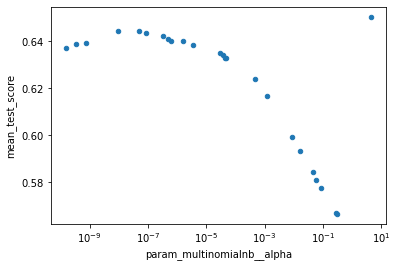

In [31]:
cv_results.plot(
    "param_multinomialnb__alpha", "mean_test_score", kind="scatter", logx=True
)

This plot has a clear pattern of a negative relationship between average test score and multinomial alpha values. Let's add the minimum count to the cross validation search to see if we can get any better parameters. 

In [54]:
%%time

search = RandomizedSearchCV(
    mnb,
    {
        "countvectorizer__min_df": randint(1, 5),
        "multinomialnb__alpha": loguniform(1e-10, 1e-5),
    },
    n_iter=25,
    scoring="f1",
)
search.fit(df["tokens"], df["pol"])

CPU times: user 20.6 s, sys: 2.54 s, total: 23.1 s
Wall time: 2min 14s


RandomizedSearchCV(estimator=Pipeline(steps=[('countvectorizer',
                                              CountVectorizer(analyzer=<cyfunction identity at 0x7f68120611e0>,
                                                              max_df=0.65)),
                                             ('multinomialnb',
                                              MultinomialNB(alpha=4.59e-08))]),
                   n_iter=25,
                   param_distributions={'countvectorizer__min_df': <scipy.stats._distn_infrastructure.rv_frozen object at 0x7f675d976df0>,
                                        'multinomialnb__alpha': <scipy.stats._distn_infrastructure.rv_frozen object at 0x7f675d91f2e0>},
                   scoring='f1')

In [55]:
search.best_params_, search.best_score_

({'countvectorizer__min_df': 1, 'multinomialnb__alpha': 1.205619178031891e-07},
 0.6440587899593543)

Now, we get a much smaller multinomial alpha value.

In [56]:
cv_results = pd.DataFrame(search.cv_results_)

<AxesSubplot:xlabel='param_countvectorizer__min_df', ylabel='mean_test_score'>

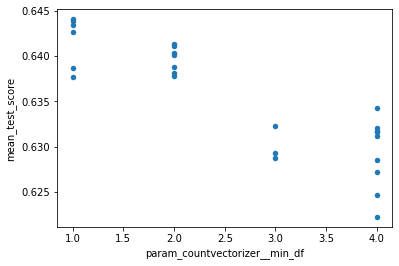

In [57]:
cv_results.plot("param_countvectorizer__min_df", "mean_test_score", kind="scatter")

Now, we see a negative relationship average test score and count vectorizer  minimum value. 

<AxesSubplot:xlabel='param_multinomialnb__alpha', ylabel='mean_test_score'>

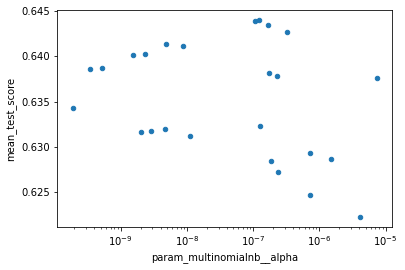

In [59]:
cv_results.plot(
    "param_multinomialnb__alpha", "mean_test_score", kind="scatter", logx=True
)

<AxesSubplot:xlabel='param_multinomialnb__alpha', ylabel='mean_test_score'>

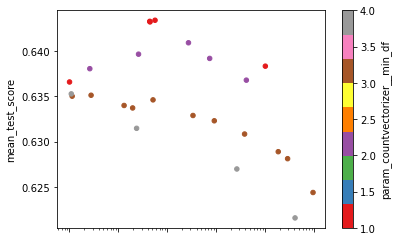

In [39]:
cv_results.plot(
    "param_multinomialnb__alpha",
    "mean_test_score",
    kind="scatter",
    logx=True,
    c="param_countvectorizer__min_df",
    colormap="Set1",
)

The plot of average test score and multinomial alpha is a little bit more random now. However, we can still see a negative pattern. Let's tune the model a bit more. 

In [41]:
%%time

search = RandomizedSearchCV(
    mnb,
    {
        "countvectorizer__min_df": [1],
        "countvectorizer__max_df": uniform(0.5, 0.5),
        "multinomialnb__alpha": loguniform(1e-10, 1e-5),
    },
    n_iter=25,
    scoring="f1",
)
search.fit(df["tokens"], df["pol"])

CPU times: user 21.1 s, sys: 2.64 s, total: 23.7 s
Wall time: 3min 52s


RandomizedSearchCV(estimator=Pipeline(steps=[('countvectorizer',
                                              CountVectorizer(analyzer=<cyfunction identity at 0x7f68120611e0>)),
                                             ('multinomialnb',
                                              MultinomialNB())]),
                   n_iter=25,
                   param_distributions={'countvectorizer__max_df': <scipy.stats._distn_infrastructure.rv_frozen object at 0x7f675f644490>,
                                        'countvectorizer__min_df': [1],
                                        'multinomialnb__alpha': <scipy.stats._distn_infrastructure.rv_frozen object at 0x7f675f532bb0>},
                   scoring='f1')

In [42]:
search.best_params_, search.best_score_

({'countvectorizer__max_df': 0.6523872547443941,
  'countvectorizer__min_df': 1,
  'multinomialnb__alpha': 4.4944393080608544e-08},
 0.6454929212810179)

Now that we have added a new parameter, we have a very small alpha, maximum count vectorizer of 0.65 and a minimum count vectorizer of 1. 

<AxesSubplot:xlabel='param_countvectorizer__max_df', ylabel='mean_test_score'>

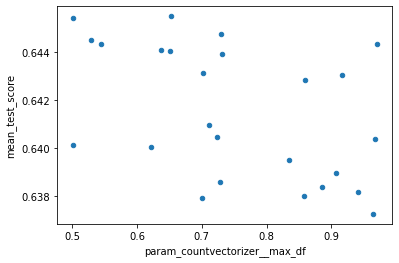

In [43]:
cv_results = pd.DataFrame(search.cv_results_)
cv_results.plot("param_countvectorizer__max_df", "mean_test_score", kind="scatter")

The plot of average test score vs maximum count vectorizor is very random. We can barely see any pattern.

---

### Evaluate final model

In [45]:
mnb.set_params(
    multinomialnb__alpha=4.59e-08, countvectorizer__min_df=1, countvectorizer__max_df=0.65
)

Pipeline(steps=[('countvectorizer',
                 CountVectorizer(analyzer=<cyfunction identity at 0x7f68120611e0>,
                                 max_df=0.65)),
                ('multinomialnb', MultinomialNB(alpha=4.59e-08))])

In [46]:
predicted = cross_val_predict(mnb, df["tokens"], df["pol"], cv=cv, n_jobs=-1)
print(classification_report(df["pol"], predicted))

              precision    recall  f1-score   support

       False       0.98      0.95      0.97     56243
        True       0.53      0.81      0.64      4266

    accuracy                           0.94     60509
   macro avg       0.76      0.88      0.80     60509
weighted avg       0.95      0.94      0.94     60509



The final model has an increased f1 score of .64. In addition, the true precision also increases along with the accuracy. Therefore, the hyperparameter searching process helped the model to be more accurate.